# TUGAS PRA UAS

## 1. Data Set

https://archive.ics.uci.edu/dataset/45/heart+disease

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

## 2.	Data understanding
### a.	Fitur atau variable data


Berdasarkan dokumentasi dataset Cleveland (14 fitur utama + target `num`):

* **age**: usia pasien (tahun)
* **sex**: jenis kelamin (1=pria, 0=wanita)
* **cp**: tipe nyeri dada (1–4: tipikal, atipikal, non-anginal, asimtomatik)
* **trestbps**: tekanan darah istirahat (mm Hg)
* **chol**: kolesterol serum (mg/dl)
* **fbs**: gula darah puasa > 120 mg/dl (1 = ya, 0 = tidak)
* **restecg**: hasil ECG istirahat (0=normal, 1=ST-T abnormal, 2=LV hypertrophy)
* **thalach**: denyut jantung maksimum dicapai
* **exang**: angina akibat latihan (1 = ya, 0 = tidak)
* **oldpeak**: depresi ST karena latihan relatif istirahat
* **slope**: kemiringan segmen ST saat puncak latihan (1 = naik, 2 = datar, 3 = turun)
* **ca**: jumlah pembuluh utama (0–3) terlihat melalui fluoroskopi
* **thal**: hasil tes thalassemia (3 = normal, 6 = fixed defect, 7 = reversible defect)
* **num** *(target)*: 0 = tidak ada penyakit, 1–4 = adanya penyakit (biasanya dibinerisasi menjadi 0/1)

### b. Ekplorasi data

* **Missing values**: Beberapa dataset (Hungary, Switzerland, Cleveland) memiliki missing di fitur seperti `ca`, `thal` perlu dicek & imputasi jika diperlukan .
* **Outlier**: Beberapa fitur numerik seperti `chol`, `trestbps`, `oldpeak` punya outlier ekstrem. Identifikasi lewat boxplot IQR/visualisasi.
* **Distribusi**: Fitur kategorikal (`cp`, `sex`, `exang`, `slope`) perlu dicek distribusinya, fitur numerik bisa dilihat dari histogram dan density plot.

Dataset Cleveland dari UCI dimuat dari file yang tidak memiliki header, sehingga setiap kolom diberi nama secara manual agar dapat dikenali dan dianalisis dengan baik. Setelah data dimuat, dilakukan pengecekan terhadap nilai hilang. Dataset ini menggunakan tanda “?” sebagai indikator nilai yang hilang, sehingga karakter tersebut diganti dengan nilai `NaN` agar dapat dikenali dan diproses oleh sistem.

Setelah nilai hilang ditandai dengan `NaN`, dilakukan perhitungan jumlah missing value untuk setiap kolom. Hasilnya menunjukkan bahwa kolom `ca` dan `thal` merupakan fitur yang memiliki nilai kosong. Kedua kolom tersebut pada awalnya bertipe data objek (karena mengandung karakter “?”), sehingga perlu dikonversi menjadi numerik. Proses konversi dilakukan dengan mengubah seluruh isi kolom ke tipe numerik, dan bila terdapat nilai yang tidak bisa diubah, akan secara otomatis dijadikan `NaN`.

Selanjutnya, dilakukan eksplorasi visual untuk mendeteksi nilai-nilai ekstrem atau outlier pada fitur-fitur numerik. Lima fitur dipilih untuk divisualisasikan, yaitu `age`, `trestbps`, `chol`, `thalach`, dan `oldpeak`. Masing-masing fitur ditampilkan dalam bentuk boxplot. Melalui boxplot ini, dapat dilihat sebaran data, nilai minimum dan maksimum, serta apakah terdapat nilai yang berada jauh di luar rentang mayoritas data (yang ditandai dengan titik-titik di luar kotak atau whisker). Outlier ini penting untuk diidentifikasi karena dapat mempengaruhi interpretasi data atau proses pelatihan model, terutama jika algoritma yang digunakan sensitif terhadap nilai ekstrem.



Jumlah missing value per kolom:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


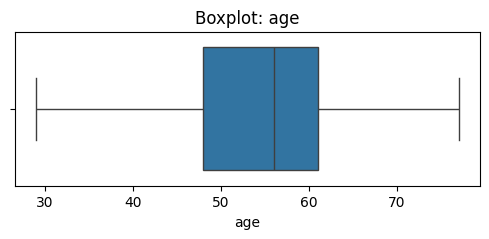

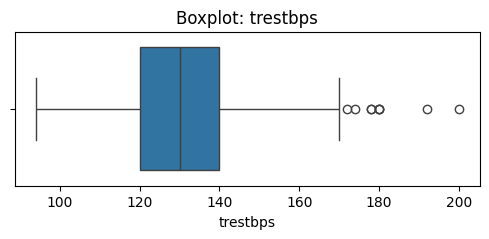

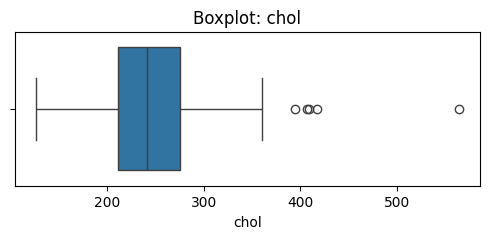

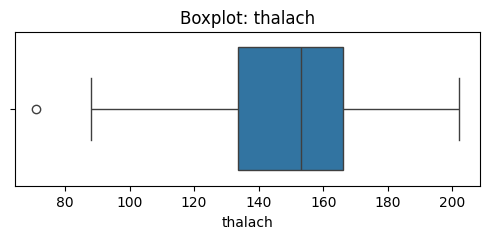

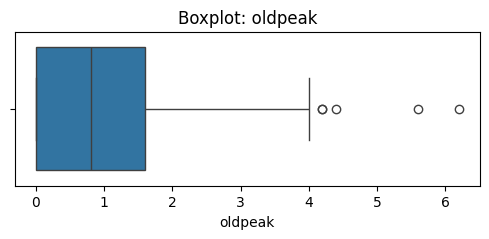

In [3]:
# Load data
import pandas as pd
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
    names=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
           "exang", "oldpeak", "slope", "ca", "thal", "target"]
)

# Cek nilai hilang ("?" dianggap missing)
df.replace("?", pd.NA, inplace=True)
missing = df.isna().sum()
print("Jumlah missing value per kolom:")
print(missing)

# Konversi kolom numerik yang ada missing-nya
df["ca"] = pd.to_numeric(df["ca"], errors='coerce')
df["thal"] = pd.to_numeric(df["thal"], errors='coerce')

# Cek outlier dengan boxplot
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
for col in numeric_cols:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
    plt.show()

### c. Visualisasi

* **Histogram/boxplot** distribusi tiap fitur numerik untuk deteksi outlier & skewness.
* **Bar chart** untuk kategori (`cp`, `thal`, `exang`).
* **Correlation heatmap** antara fitur-fitur numerik, dan antara fitur dan target.
* **Pairplot atau scatter** untuk hubungan antara variabel dan label.
* **Countplot** pembagian label (`num` binari).

Setelah data dibersihkan dari nilai-nilai kosong dengan menggunakan fungsi `dropna()`, semua baris yang memiliki setidaknya satu nilai `NaN` dihapus dari dataset. Langkah ini memastikan bahwa seluruh data yang akan diproses pada tahap selanjutnya adalah lengkap dan tidak mengandung informasi yang hilang.

Kolom `target` yang awalnya mengandung nilai numerik dari 0 hingga 4 kemudian dikonversi menjadi biner. Hal ini dilakukan karena dalam konteks analisis ini, fokusnya adalah membedakan antara pasien yang memiliki indikasi penyakit jantung dan yang tidak. Nilai `0` menandakan tidak ada penyakit, sementara nilai `1` mewakili adanya kondisi jantung (yang semula ditandai oleh nilai 1 hingga 4). Dengan demikian, klasifikasi dikembalikan ke bentuk dua kelas (binary classification), yaitu `0` dan `1`.

Setelah data bersih dan target telah diklasifikasikan ulang, dilakukan analisis korelasi antar fitur. Visualisasi ini menggunakan heatmap yang menampilkan nilai korelasi Pearson antara setiap pasangan fitur numerik. Warna dalam heatmap menunjukkan seberapa kuat hubungan antar fitur, dengan nilai mendekati 1 atau -1 menunjukkan hubungan yang kuat (positif atau negatif), dan nilai mendekati 0 menunjukkan tidak ada korelasi yang signifikan. Heatmap ini berguna untuk mengidentifikasi fitur yang saling berkaitan atau redundant, serta melihat fitur mana yang paling berhubungan dengan target.

Terakhir, distribusi kelas target ditampilkan menggunakan countplot. Grafik ini menunjukkan jumlah data pada masing-masing kelas, yaitu jumlah pasien yang tidak memiliki penyakit jantung (`0`) dan yang memiliki (`1`). Visualisasi ini membantu untuk mengetahui apakah data target seimbang atau tidak. Jika distribusi sangat timpang, hal ini bisa menjadi pertimbangan untuk penyesuaian model atau teknik sampling selanjutnya.



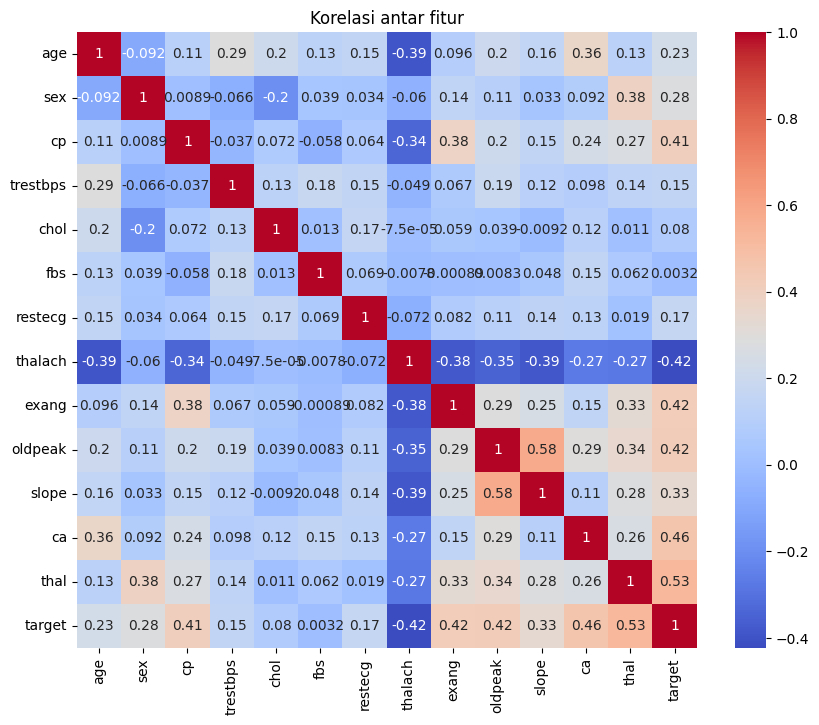

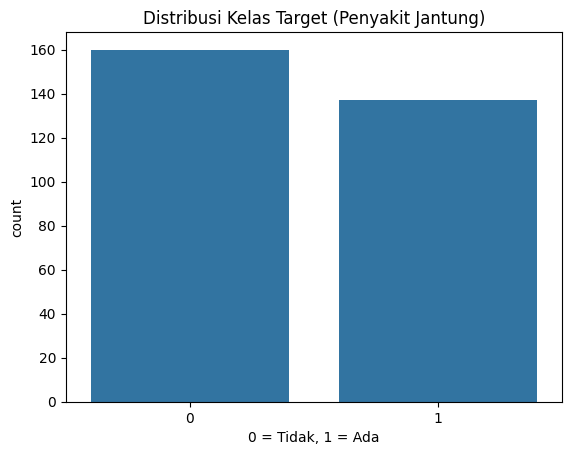

In [4]:
# Hapus data yang masih ada nilai kosong
df.dropna(inplace=True)

# Ubah target menjadi biner: 0 (tidak sakit), 1 (sakit)
df["target"] = df["target"].astype(int)
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

# Korelasi antar fitur
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Korelasi antar fitur")
plt.show()

# Distribusi target
sns.countplot(x="target", data=df)
plt.title("Distribusi Kelas Target (Penyakit Jantung)")
plt.xlabel("0 = Tidak, 1 = Ada")
plt.show()



## 3. Data Preprocessing

Langkah yang general digunakan:

1. **Handling missing**

   * Jika missing relatif sedikit (misal <5%), perform imputasi (mean/median) atau hapus baris.

2. **Encoding fitur kategorikal**

   * `cp`, `restecg`, `slope`, `thal`, `sex`, `fbs`, `exang`: menggunakan one-hot (untuk dt bisa jugak label encoding).

3. **Normalisasi / scaling**

   * Untuk decision tree umumnya tidak diperlukan, tapi bisa diuji.

4. **Feature engineering** (opsional)

   * Contoh: pembuatan bin seperti `age_group`, rasio faktor risiko, polinomial.

5. **Feature selection / reduksi dimensi (opsional)**

   * Bisa gunakan PCA atau seleksi berbasis feature importance decision tree.




Dataset *Heart Disease* dimuat dari sumber UCI dengan memberikan nama-nama kolom secara manual. Setelah data dimuat, nilai "?" yang menandakan data hilang diganti dengan `np.nan`, agar dapat dikenali sebagai nilai kosong oleh pustaka `pandas`. Dua kolom yang mengandung data bertipe non-numerik karena nilai "?" (`ca` dan `thal`) kemudian dikonversi menjadi tipe data numerik menggunakan fungsi `pd.to_numeric` dengan parameter `errors='coerce'`, yang secara otomatis mengubah data yang tidak dapat dikonversi menjadi `NaN`.

Setelah nilai hilang dikenali, dilakukan pencetakan jumlah nilai kosong per kolom untuk melihat sebarannya. Baris-baris yang mengandung `NaN` dihapus dari dataset menggunakan `dropna()`, untuk memastikan bahwa seluruh data yang tersisa lengkap dan siap untuk diproses lebih lanjut. Jumlah total data setelah pembersihan dicetak untuk diketahui.

Langkah selanjutnya adalah menyederhanakan label target menjadi dua kelas. Nilai pada kolom `target`, yang awalnya memiliki nilai 0–4, dikonversi menjadi `int` dan diubah menjadi biner dengan aturan: nilai 0 tetap sebagai 0 (menandakan tidak sakit), sementara nilai di atas 0 diubah menjadi 1 (menandakan indikasi penyakit jantung).

Setelah itu, dilakukan proses one-hot encoding terhadap kolom-kolom kategorikal, yaitu `cp`, `restecg`, `slope`, dan `thal`. One-hot encoding dilakukan untuk mengubah data kategorikal menjadi format numerik biner, agar dapat digunakan dalam proses pelatihan model. Parameter `drop_first=True` digunakan agar salah satu kategori dihapus sebagai referensi untuk menghindari multikolinearitas.

Dataset kemudian dipisahkan menjadi fitur (X) dan target (y). Proses split data dilakukan dengan `train_test_split`, di mana 70% data digunakan untuk pelatihan (training), dan 30% sisanya digunakan untuk pengujian (testing). Parameter `stratify=y` memastikan distribusi label target tetap seimbang di kedua subset data.

Setelah pembagian data dilakukan, dicetak informasi penting terkait dataset: jumlah fitur yang digunakan, jumlah total data, serta jumlah data pelatihan dan pengujian. Selain itu, distribusi kelas target ditampilkan dalam bentuk proporsi untuk masing-masing subset (train dan test), guna memastikan tidak terjadi ketimpangan data. Terakhir, lima baris pertama dari data fitur pelatihan (`X_train`) ditampilkan sebagai contoh.







In [9]:
# Import pustaka yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
           "exang", "oldpeak", "slope", "ca", "thal", "target"]

df = pd.read_csv(url, names=columns)

# Tangani missing value (nilai "?")
df.replace("?", np.nan, inplace=True)
df["ca"] = pd.to_numeric(df["ca"], errors="coerce")
df["thal"] = pd.to_numeric(df["thal"], errors="coerce")

# Cek jumlah nilai kosong
print(" Missing value per kolom:\n", df.isnull().sum())

# Drop baris dengan missing value
df.dropna(inplace=True)
print(f"\n Jumlah data setelah drop missing value: {len(df)} baris")

# Konversi label target menjadi biner
df["target"] = df["target"].astype(int)
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

# One-hot encoding untuk kolom kategorikal
df_encoded = pd.get_dummies(df, columns=["cp", "restecg", "slope", "thal"], drop_first=True)

# Pisahkan fitur dan label
X = df_encoded.drop("target", axis=1)
y = df_encoded["target"]

#  Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#  Tampilkan informasi hasil split
print("\n Informasi dataset:")
print(f"- Jumlah fitur       : {X.shape[1]}")
print(f"- Total data         : {len(df)}")
print(f"- Data latih (train) : {X_train.shape[0]}")
print(f"- Data uji   (test)  : {X_test.shape[0]}")

#  Cek proporsi kelas
print("\n Distribusi label (target):")
print("Train set:")
print(y_train.value_counts(normalize=True).rename({0: "Tidak sakit", 1: "Sakit"}))
print("Test set:")
print(y_test.value_counts(normalize=True).rename({0: "Tidak sakit", 1: "Sakit"}))

# Tampilkan 5 baris pertama dari X_train
print("\n Contoh data X_train:")
print(X_train.head())

 Missing value per kolom:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

 Jumlah data setelah drop missing value: 297 baris

 Informasi dataset:
- Jumlah fitur       : 18
- Total data         : 297
- Data latih (train) : 207
- Data uji   (test)  : 90

 Distribusi label (target):
Train set:
target
Tidak sakit    0.541063
Sakit          0.458937
Name: proportion, dtype: float64
Test set:
target
Tidak sakit    0.533333
Sakit          0.466667
Name: proportion, dtype: float64

 Contoh data X_train:
      age  sex  trestbps   chol  fbs  thalach  exang  oldpeak   ca  cp_2.0  \
115  41.0  1.0     135.0  203.0  0.0    132.0    0.0      0.0  0.0    True   
94   63.0  0.0     135.0  252.0  0.0    172.0    0.0      0.0  0.0   False   
186  42.0  1.0     120.0  240.0  1.0    194.0    0.0      0.8  0.0   False   
68   59.0  1.0     170.0






## 4. Model: Decision Tree Classification

* Ubah num menjadi biner: 0 (no disease) vs ≥1 (disease).
* Bagi data train/test (misal 70/30) dengan stratifikasi label.
* Bangun model decision tree (scikit‑learn DecisionTreeClassifier) dengan parameter: max\_depth, min\_samples\_leaf, dan criterion (gini/entropy).
* Gunakan cross-validation untuk tuning hyperparameter (GridSearchCV).
* Visualisasikan pohon untuk interpretasi fitur penting.





In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Grid search untuk mencari parameter terbaik
param_grid = {
    "max_depth": [3, 5, 7, None],
    "min_samples_leaf": [1, 5, 10],
    "criterion": ["gini", "entropy"]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="f1"
)
grid.fit(X_train, y_train)

# Model terbaik
model = grid.best_estimator_
print("Parameter terbaik:", grid.best_params_)

Parameter terbaik: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1}


## 5. Evaluasi Model

* Ukur performa menggunakan:

  * **Accuracy**, **Precision**, **Recall**, **F1‑score**, **ROC-AUC**.
* Tampilkan:

  * **Confusion matrix**.
  * **ROC curve** dengan AUC.
* Interpretasi hasil:

  * Bandingkan performance antar parameter; seimbangkan antara overfitting (terlalu dalam) dan underfitting (terlalu dangkal).


Setelah model terbaik diperoleh melalui proses Grid Search, dilakukan evaluasi kinerjanya menggunakan data uji. Prediksi dilakukan dalam dua bentuk: kelas prediksi (`y_pred`) dan probabilitas prediksi (`y_proba`). Kelas prediksi digunakan untuk evaluasi klasifikasi secara umum, sedangkan probabilitas digunakan untuk analisis lebih lanjut seperti ROC Curve.

### Evaluasi Klasifikasi

1. **Classification Report**
   Fungsi `classification_report` dari `sklearn.metrics` menghasilkan metrik evaluasi standar klasifikasi: precision, recall, f1-score, dan support untuk masing-masing kelas. Metrik ini berguna untuk melihat kekuatan dan kelemahan model, terutama pada klasifikasi biner dengan distribusi kelas yang tidak seimbang.

2. **Confusion Matrix**
   Matriks ini menampilkan jumlah prediksi benar dan salah untuk masing-masing kelas. Nilai ini membantu memahami tipe kesalahan yang paling sering dilakukan model (false positives dan false negatives).

### Analisis ROC Curve dan AUC

3. **ROC Curve dan AUC Score**
   ROC (Receiver Operating Characteristic) Curve dibuat dengan menghitung True Positive Rate (TPR) dan False Positive Rate (FPR) dari probabilitas prediksi. Skor AUC (Area Under the Curve) dihitung menggunakan `roc_auc_score` dan mencerminkan kemampuan model membedakan antara dua kelas. Nilai AUC mendekati 1 menandakan model yang sangat baik.

   Visualisasi ROC Curve menampilkan kurva TPR terhadap FPR. Garis diagonal abu-abu sebagai referensi menggambarkan model acak. Kurva model yang berada jauh di atas garis tersebut menunjukkan performa yang lebih baik dari tebakan acak.

### Visualisasi Struktur Pohon Keputusan

4. **Visualisasi Decision Tree**
   Setelah evaluasi, dilakukan visualisasi struktur pohon keputusan menggunakan `plot_tree`. Visualisasi ini menunjukkan bagaimana model membuat keputusan berdasarkan fitur-fitur yang digunakan, nilai split, dan distribusi kelas di setiap node. Visualisasi membantu dalam interpretasi model karena Decision Tree bersifat transparan dan mudah dipahami.


Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        48
           1       0.77      0.71      0.74        42

    accuracy                           0.77        90
   macro avg       0.77      0.76      0.76        90
weighted avg       0.77      0.77      0.77        90

Confusion Matrix:
[[39  9]
 [12 30]]
ROC AUC Score: 0.8653273809523809


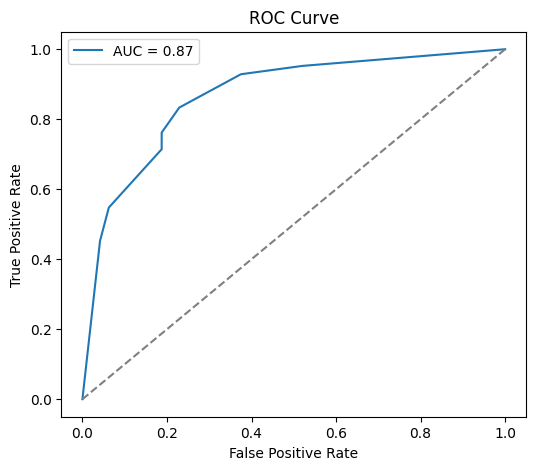

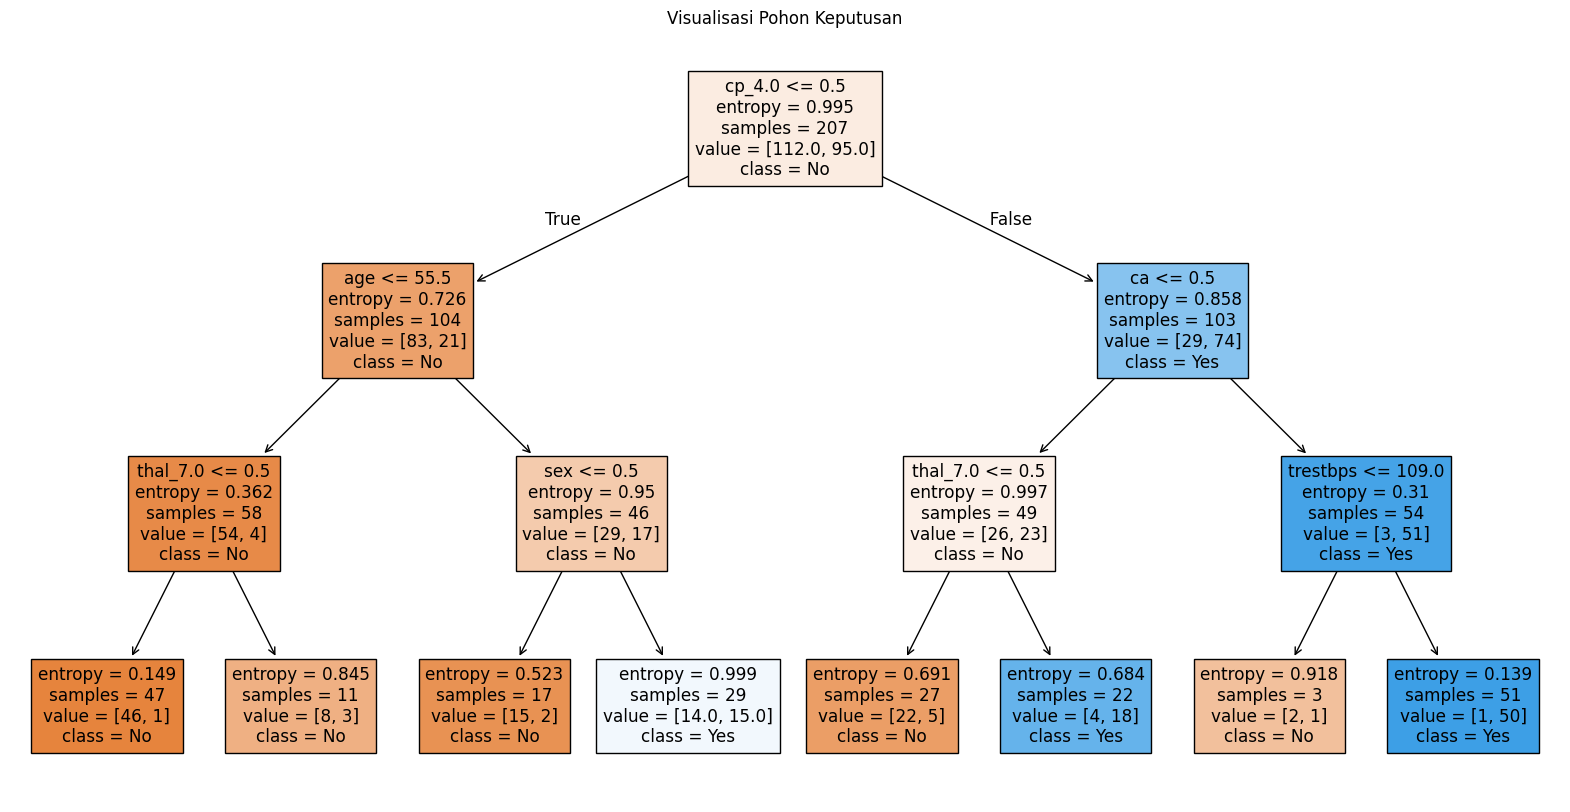

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Prediksi dan evaluasi
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", roc_score)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Visualisasi pohon
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=["No", "Yes"], filled=True)
plt.title("Visualisasi Pohon Keputusan")
plt.show()